In [2]:
using Distributed, OnlineStats, LibPQ, DataStreams, DataFrames, SharedArrays, Suppressor, Distributions, SparseArrays, IJulia, Plots

### Create workers

In [3]:
addprocs(4)
@everywhere using LinearAlgebra, LibPQ, DataFrames, SparseArrays, SharedArrays, OnlineStats, DataStreams

### Cost function

In [27]:
@inline function predict(i::Int64, u::Int64, μ::Float64, P::SharedMatrix{Float64,}, Q::SharedMatrix{Float64})::Float64
    @views μ + P[i,2] + Q[u,2] + dot(P[i, 3:end],Q[u, 3:end])
end

function db_get_rows(conn::LibPQ.Connection, table::Symbol, limit::Int64, offset::Int64)::LibPQ.Result
    LibPQ.execute(conn, """
        SELECT
            "movieId",
            "userId",
            "rating"
        FROM $table
        LIMIT $limit
        OFFSET $offset;
    """);
end

function cost(conn::LibPQ.Connection, table::Symbol,
        item_map::SparseVector{Int64,Int64}, user_map::SparseVector{Int64,Int64},
        P::SharedMatrix{Float64,}, Q::SharedMatrix{Float64},
        μ::Float64)::Float64

    limit::Int64 = 10000
    offset::Int64 = 0
    total::Float64 = 0.0
    i::Int64 = 0
    u::Int64 = 0
    nrows::Int64 = 0

    while true
        res = db_get_rows(conn, table, limit, offset)
        nrows = num_rows(res)

        @fastmath @inbounds for row in Data.rows(res)
            i = item_map[row.movieId]
            u = user_map[row.userId]
            total += abs2(predict(i, u, μ, P, Q) - row.rating)
        end

        if nrows < limit
            break
        end

        offset += limit
    end

    total
end

cost (generic function with 1 method)

### Lstq function

In [28]:
@everywhere function db_select_rows(conn::LibPQ.Connection, table::Symbol,
        src_column::Symbol, dst_column::Symbol,
        bounds::UnitRange{Int64},
        limit::Int64, offset::Int64)::LibPQ.Result
    LibPQ.execute(conn, """
        WITH a AS (
            SELECT
                *
            FROM $table
            WHERE "$dst_column" BETWEEN $(minimum(bounds)) AND $(maximum(bounds))
            ORDER BY ("$dst_column", "$src_column")
            LIMIT $limit
            OFFSET $offset
        )
        
        SELECT
            array_agg("$src_column") as "$src_column",
            "$dst_column",
            array_agg("rating") as "rating"
        FROM a
        GROUP BY "$dst_column"
        ORDER BY "$dst_column";
    """);
end

@everywhere function lstq(table::Symbol, bounds::UnitRange{Int64},
        src_column::Symbol, dst_column::Symbol,
        src_map::SparseVector{Int64,Int64}, dst_map::SparseVector{Int64,Int64},
        S::SharedMatrix{Float64,}, D::SharedMatrix{Float64},
        μ::Float64, reg::Float64)::Nothing
    
    global conn
    
    limit::Int64 = 10000
    offset::Int64 = 0
    current_id::Int64 = minimum(bounds)
    src_indices::Vector{Int64} = []
    count::Int64 = 0
    m::Int64, n::Int64 = size(S)
    X = zeros(n-1, n-1)
    y = zeros(n-1)
    
    while true
        res = db_select_rows(conn, table, src_column, dst_column, bounds, limit, offset)
        
        @fastmath @inbounds @views for row = Data.rows(res)
            count += length(row[src_column])
            
            if row[dst_column] != current_id
                D[dst_map[current_id], 2:end] .= cholesky(X + reg*I) \ (y)
                
                current_id = row[dst_column]
                
                fill!(X, zero(Float64))
                fill!(y, zero(Float64))
            end
            
            src_indices = src_map[row[src_column]]
            A = S[src_indices, [1; 3:end]]
            b = row[:rating] .- μ .- S[src_indices, 2]
            X .+= A'A
            y .+= A'b
        end
        
        if count < limit
            @fastmath @inbounds @views D[dst_map[current_id], 2:end] .= cholesky(X + reg*I) \ (y)
            break
        end
        
        count = 0
        offset += limit
    end
    nothing
end

### ALS function

In [6]:
@everywhere function db_set_work_memory(conn::LibPQ.Connection)::Nothing
    LibPQ.execute(conn, """ 
        SET work_mem TO '1 GB';
    """);
    nothing
end

function db_mean(conn::LibPQ.Connection, table::Symbol, column::Symbol)::Float64
    collect(skipmissing(fetch!(NamedTuple, LibPQ.execute(conn, """
        SELECT
            AVG("$column") as mean
        FROM $table;
    """))[:mean]))[1];
end

function db_unique_ids(conn::LibPQ.Connection, table::Symbol, column::Symbol)::Vector{Int64}
    collect(skipmissing(fetch!(NamedTuple, LibPQ.execute(conn, """
        SELECT DISTINCT
            "$column"
        FROM $table
        ORDER BY "$column";
    """))[column]));
end

function db_split_ids(conn::LibPQ.Connection, table::Symbol, column::Symbol, chunks::Int)::Vector{UnitRange{Int64}}
    collect(UnitRange{Int64}(row.min, row.max) for row in skipmissing(Data.rows(LibPQ.execute(conn, """
        WITH a AS (
            SELECT DISTINCT
                "$column",
                trunc(
                    cume_dist() OVER (
                        ORDER BY "$column"
                    ) * (\$1 -  0.00001)
                )::int4 + 1 AS chunk
            FROM $table
            ORDER BY "$column"
        )

        SELECT
            min("$column") as min,
            max("$column") as max--,
            --array_agg("$column")::int8[] AS ids,
            --chunk 
        FROM a
        GROUP BY chunk
        ORDER BY chunk;
    """, [chunks]))));
end

function fit_factors(conn::LibPQ.Connection, table::Symbol, nepochs::Int64, μ::Float64, reg::Float64,
    item_chunks::Vector{UnitRange{Int64}}, user_chunks::Vector{UnitRange{Int64}},
    item_column::Symbol, user_column::Symbol,
    item_map::SparseVector{Int64,Int64}, user_map::SparseVector{Int64,Int64},
    P::SharedMatrix{Float64}, Q::SharedMatrix{Float64},
    cb::Union{Nothing, Function}=nothing,)::Nothing

    for epoch::Int64 in 1:nepochs
        @sync for (i,w) in enumerate(workers())
            @async remotecall_wait(lstq, w, [table, user_chunks[i], item_column, user_column, item_map, user_map, P, Q, μ, reg]...)
        end

        @sync for (i,w) in enumerate(workers())
            @async remotecall_wait(lstq, w, [table, item_chunks[i], user_column, item_column, user_map, item_map, Q, P, μ, reg]...)
        end

        if cb !== nothing
            cb(epoch, cost(conn, table, item_map, user_map, P, Q, μ))
        end
    end
    nothing
end

function als(dbstr::String, table::Symbol, k::Int64=10;
        nepochs::Int64=10,
        reg::Float64=0.0,
        cb::Union{Nothing, Function}=nothing)
    
    type_map::Dict{Symbol, Type} = Dict(:int4=>Int64, :float4=>Float64)
    
    conn = LibPQ.Connection(dbstr; type_map=type_map)
    db_set_work_memory(conn) #4 most allocating line !!!!
    
    μ::Float64 = db_mean(conn, table, :rating)
    user_ids::Vector{Int64} = db_unique_ids(conn, table, :userId)
    item_ids::Vector{Int64} = db_unique_ids(conn, table, :movieId)
    user_chunks::Vector{UnitRange{Int64}} = db_split_ids(conn, table, :userId, nworkers())
    item_chunks::Vector{UnitRange{Int64}} = db_split_ids(conn, table, :movieId, nworkers())

    m::Int64, n::Int64 = length(item_ids), length(user_ids)
    
    item_map::SparseVector{Int64,Int64} = sparsevec(item_ids, 1:m);
    user_map::SparseVector{Int64,Int64} = sparsevec(user_ids, 1:n);
    
    P::SharedMatrix{Float64} = SharedMatrix{Float64}([ones(m) zeros(m) rand(Normal(0.0, 1.0), m, k)])
    Q::SharedMatrix{Float64} = SharedMatrix{Float64}([ones(n) zeros(n) rand(Normal(0.0, 1.0), n, k)])
    
    @everywhere workers() begin
        conn = LibPQ.Connection($dbstr; type_map=$type_map)
        db_set_work_memory(conn)
    end
    
    fit_factors(conn, table, nepochs, μ, reg, item_chunks, user_chunks, :movieId, :userId, item_map, user_map, P, Q, cb)
        
    @everywhere workers() close(conn)
    close(conn)
    
    P, Q
end

als (generic function with 2 methods)

### Compute Latent Factors

epoch: 10, cost: 46.14255517889137
118.673067 seconds (31.54 M allocations: 955.108 MiB, 0.65% gc time)


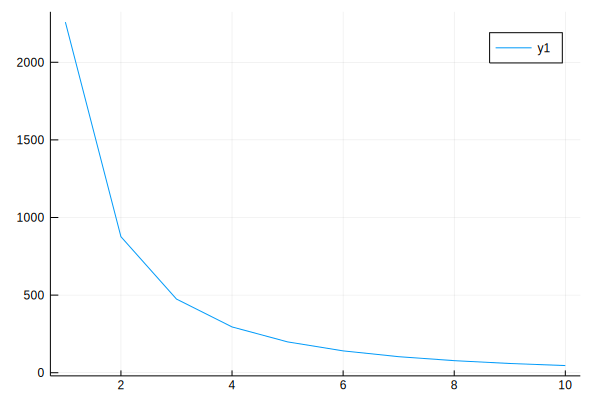

In [30]:
costs = []
    
@time P, Q = als("host=localhost dbname=postgres", :ml_small, 100;
    nepochs=10,
    reg=0.0001,
    cb=(epoch, cost)->begin
        IJulia.clear_output(true)
        println("epoch: $(epoch), cost: $(cost)")
        push!(costs, cost)
        end)

plot(costs)

### Destroy workers

In [16]:
@suppress_err rmprocs(workers())

Task (done) @0x0000000126d27190

### TODO

- Test with direct least squares on array-results from db.
- Drop OnlineStats for LinReg, adopt custom lstq function.